 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5007/ (Press CTRL+C to quit)


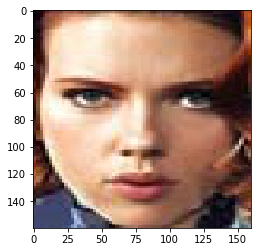

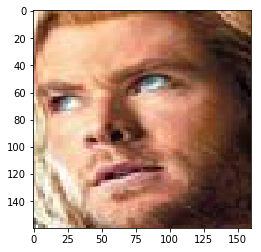

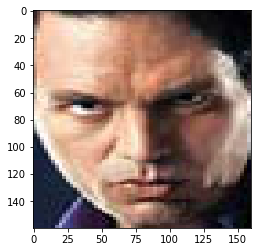

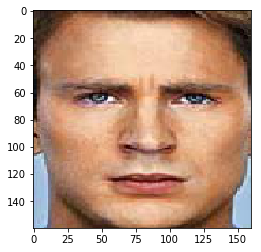

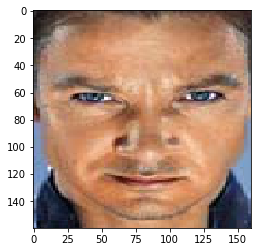

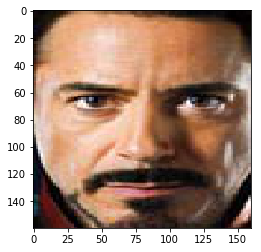

127.0.0.1 - - [12/May/2021 23:12:56] "POST /check_attd HTTP/1.1" 200 -


[array(['94'], dtype='<U2'), array(['95'], dtype='<U2'), array(['95'], dtype='<U2'), array(['95'], dtype='<U2'), array(['95'], dtype='<U2'), array(['93'], dtype='<U2')]
<class 'numpy.int64'>


127.0.0.1 - - [12/May/2021 23:13:05] "GET / HTTP/1.1" 404 -


In [21]:
from flask import Flask, render_template, request
import urllib.request

from numpy import load
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from os import listdir
from os.path import isdir
from numpy import savez_compressed
from numpy import load
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from numpy import expand_dims
import joblib
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
import json
import os

app = Flask(__name__)

@app.route('/images', methods=['POST'])
def download_images():
    images = request.json.get('images')
    #download images with ID
    
    for image in images:
        try:
            ID = image['id']
            train_path = r'images_from_base/train/'+str(ID) 
            if not os.path.exists(train_path):
                os.makedirs(train_path)
            val_path = r'images_from_base/val/'+str(ID) 
            if not os.path.exists(val_path):
                os.makedirs(val_path)
            urllib.request.urlretrieve(image['urls'][0], "images_from_base/train/"+str(ID)+"/"+str(ID)+".jpg")
            urllib.request.urlretrieve(image['urls'][1], "images_from_base/val/"+str(ID)+"/"+str(ID)+".jpg")
        except Exception as e: 
            print(e)
    #Create dataset-------------------------------------------------------------------------------------------------    
    def extract_face(filename, required_size=(160, 160)):
        print('extract_face begins----------------------------------------------------------------------------------')
        image = Image.open(filename)
        image = image.convert('RGB')

        pixels = asarray(image)
        detector = MTCNN()
        detected_faces = detector.detect_faces(pixels)
        x1, y1, width, height = detected_faces[0]['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        face = pixels[y1:y2, x1:x2]
        image = Image.fromarray(face)
        image = image.resize(required_size)
        array = asarray(image)
        print('extract_face end----------------------------------------------------------------------------------')
        return array

    def load_faces(directory):
        print('load_faces begins----------------------------------------------------------------------------------')
        faces = list()
        for filename in listdir(directory):
            path = directory + filename
            face = extract_face(path)
            faces.append(face)
        print('load_faces end----------------------------------------------------------------------------------')
        return faces

    def load_dataset(directory):
        print('load_dataset begins----------------------------------------------------------------------------------')
        X, y = list(), list()
        for subdir in listdir(directory):
            path = directory + subdir + '/'
            if not isdir(path):
                continue
            faces = load_faces(path)
            labels = [subdir for _ in range(len(faces))]
            X.extend(faces)
            y.extend(labels)
        print('load_dataset end----------------------------------------------------------------------------------')
        return asarray(X), asarray(y)

    trainX, trainy = load_dataset('images_from_base/train/')
    print(trainX.shape, trainy.shape)
    testX, testy = load_dataset('images_from_base/val/')
    savez_compressed('images_from_base.npz', trainX, trainy, testX, testy)
    print('compressed!!!----------------------------------------------------------------------------------')

    
    
    #Conv. dataset-----------------------------------------------------------------------------------------------------------
    def get_embedding(model, face_pixels):
        print('get_embedding begins----------------------------------------------------------------------------------')
        face_pixels = face_pixels.astype('float32')
        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / std
        samples = expand_dims(face_pixels, axis=0)
        yhat = model.predict(samples)
        print('get_embedding end----------------------------------------------------------------------------------')
        return yhat[0]

    data = load('images_from_base.npz')
    trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
    print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
    model = load_model('facenet_keras.h5')
    print('Loaded Model')
    newTrainX = list()
    for face_pixels in trainX:
        embedding = get_embedding(model, face_pixels)
        newTrainX.append(embedding)
    newTrainX = asarray(newTrainX)
    print(newTrainX.shape)
    newTestX = list()
    for face_pixels in testX:
        embedding = get_embedding(model, face_pixels)
        newTestX.append(embedding)
    newTestX = asarray(newTestX)
    print(newTestX.shape)
    savez_compressed('images_from_base_after_embedding.npz', newTrainX, trainy, newTestX, testy)

        #training model-----------------------------------------------------------------------------------------------------------
    data = load('images_from_base_after_embedding.npz')
    trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

    in_encoder = Normalizer(norm='l2')
    trainX = in_encoder.transform(trainX)
    testX = in_encoder.transform(testX)
    out_encoder = LabelEncoder()
    out_encoder.fit(trainy)
    trainy = out_encoder.transform(trainy)
    testy = out_encoder.transform(testy)

    model = SVC(kernel='linear', probability=True)
    model.fit(trainX, trainy)

    train_prediction = model.predict(trainX)
    test_prediction = model.predict(testX)

    train_score = accuracy_score(trainy, train_prediction)
    test_score = accuracy_score(testy, test_prediction)

    print('train=%.3f, test=%.3f' % (train_score*100, test_score*100))

    #Save model-------------------------------------------------------------------------------------------------------------
    joblib_p='SVM_model_face_recognition_from_base.sav'
    joblib.dump(model,joblib_p)

    return 'ok'
@app.route('/check_attd', methods=['POST'])
def check_attd():
    image = request.files.get('images')
    image.save('image.jpg')
    model = joblib.load('SVM_model_face_recognition_from_base.sav')
    photo_path='image.jpg'
    def recognition(photo_path):
            data = load('images_from_base_after_embedding.npz')
            trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
            out_encoder = LabelEncoder()
            out_encoder.fit(trainy)
            required_size=(160, 160)
            image = Image.open(photo_path)
            image = image.convert('RGB')
            pixels = asarray(image)
            detector = MTCNN()
            detected_faces = detector.detect_faces(pixels)

            times=len(detected_faces)
            all_faces=list()
            for i in range(times):
                x1, y1, width, height = detected_faces[i]['box']
                x1, y1 = abs(x1), abs(y1)
                x2, y2 = x1 + width, y1 + height
                face = pixels[y1:y2, x1:x2]
                image = Image.fromarray(face)
                image = image.resize(required_size)
                face_array = asarray(image)
                all_faces.append(face_array)
                pyplot.imshow(face_array)
                pyplot.show()


            def get_embedding(facenet_model, face_pixels):
                face_pixels = face_pixels.astype('float32')
                mean, std = face_pixels.mean(), face_pixels.std()
                face_pixels = (face_pixels - mean) / std
                samples = expand_dims(face_pixels, axis=0)
                prediction = facenet_model.predict(samples)
                return prediction[0]
            facenet_model = load_model('facenet_keras.h5')
            newList=list()
            for faces in all_faces:  
                q=get_embedding(facenet_model,faces)
                newList.append(q)
            newList = asarray(newList)

            in_encoder = Normalizer(norm='l2')
            newList=in_encoder.transform(newList)
            all_predicted_names=list()
            for sample in newList:
                samples = expand_dims(sample, axis=0)
                class_prediction = model.predict(samples)
                class_index = class_prediction[0]
                predicted_names = out_encoder.inverse_transform(class_prediction)
                all_predicted_names.append(predicted_names)
                
                #print('Predicted: %s' % (predicted_names[0]))
            print(all_predicted_names)
            print(type(class_index))
            return all_predicted_names
    arr=list()
    for i in recognition(photo_path):
        arr.append(int(i))
    return json.dumps(arr)
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5007)
